# Data Preprocessing

In [1]:
import pandas as pd 
# Load the NYT dataset
nyt_df = pd.read_csv("China_article_nyt2024.csv")
nyt_df.head()

,headline,pub_date,web_url,news_desk,document_type,snippet,abstract,lead_paragraph,is_china_related,full_text
0,China Auto Giant BYD Sells More Electric Vehic...,2024-01-01T12:43:30+0000,https://www.nytimes.com/2024/01/01/business/by...,Business,article,"Sales by BYD, the country’s dominant automaker...","Sales by BYD, the country’s dominant automaker...",The Chinese corporate giant BYD said Monday th...,True,"ADVERTISEMENT Sales by BYD, the country’s domi..."
1,India Is Chasing China’s Economy. But Somethin...,2024-01-02T05:01:27+0000,https://www.nytimes.com/2024/01/02/business/in...,Business,article,Long-term investment in India by businesses is...,Long-term investment in India by businesses is...,India’s economy is booming. Stock prices are t...,True,Long-term investment in India by businesses is...
2,"Jimmy Lai, Hong Kong Media Executive, Pleads N...",2024-01-02T11:00:05+0000,https://www.nytimes.com/2024/01/02/world/asia/...,Foreign,article,The prosecution accused him of colluding with ...,The prosecution accused him of colluding with ...,"Jimmy Lai, a veteran pro-democracy figure in H...",True,ADVERTISEMENT The prosecution accused him of c...
3,Abrupt Dismissals Point to Xi Jinping’s Quiet ...,2024-01-03T06:32:24+0000,https://www.nytimes.com/2024/01/03/world/asia/...,Foreign,article,The purge of several commanders from China’s l...,The purge of several commanders from China’s l...,The expelled officials included some of the br...,True,ADVERTISEMENT The purge of several commanders ...
4,Thursday Briefing: Blasts in Iran Kill Dozens,2024-01-03T21:04:18+0000,https://www.nytimes.com/2024/01/03/briefing/ir...,NYTNow,article,"Plus, China shakes up its military.","Plus, China shakes up its military.",A pair of explosions yesterday at a commemorat...,True,"ADVERTISEMENT Plus, China shakes up its milita..."


In [2]:
#check the data with unknown newsdesk
print(nyt_df[nyt_df['news_desk'] == 'Unknown'])
# change all unkonwn nesdesk to multimedia
nyt_df.loc[nyt_df['news_desk'] == 'Unknown', 'news_desk'] = 'Multimedia'
print(nyt_df[nyt_df['news_desk'] == 'Unknown'])


                                              headline  \
45      Landslide in China Wipes Out Fields and Houses   
85         Heavy Snow in China Disrupts Holiday Travel   
100             Chasing Indonesia’s Massive Youth Vote   
175  United States House Passes Bill That Could Ban...   
185  Biden Embraces TikTok Amid National Security C...   
210  TikTok Changed His Life. Then India Banned the...   
253                  Powerful Earthquake Shakes Taiwan   
256                  Powerful Earthquake Shakes Taiwan   
260  Workers Stuck on Mountain After Taiwan Earthquake   
316  Behind Our Investigation Into a Chinese Doping...   
319  ‘History Will Judge It Well,’ Speaker Johnson ...   
327             Earthquakes in Taiwan Damage Buildings   
339  Biden Says Aid Bill for Ukraine and Israel Wil...   
372                On the Road for a Modern Pilgrimage   
376  University of Chicago President Says Pro-Pales...   
384                                Will You Look at Me   
423           

In [3]:
# drop where full text is missing
nyt_df = nyt_df.dropna(subset=["full_text"])

In [4]:
# drop the newsdesk where articles length less than 10
news_desk_drop=["Business Day", "Multimedia", "Technology", "World"]
nyt_df = nyt_df[~nyt_df["news_desk"].isin(news_desk_drop)]

In [5]:
#clean the date column
nyt_df["pub_date"] = pd.to_datetime(nyt_df["pub_date"], errors='coerce').dt.date
nyt_df.dropna(subset=["pub_date"], inplace=True)
print(nyt_df["pub_date"].head())

0    2024-01-01
1    2024-01-02
2    2024-01-02
3    2024-01-03
4    2024-01-03
Name: pub_date, dtype: object


Data cleaning

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

nyt_df['clean_text'] = nyt_df['full_text'].apply(preprocess)

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# LDA

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(nyt_df['clean_text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Print topics
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: tiktok said trump state company china american united chinese biden
Topic 1: like think people going tiktok thing really time say right
Topic 2: term said hong kong time updated new trump election year
Topic 3: taiwan china chinese said military island state beijing official united
Topic 4: china said chinese year country state people official government foreign
Topic 5: said company chinese china year biden tariff vehicle state electric
Topic 6: china said year chinese government country economy city people woman
Topic 7: company china said year india chinese new tesla factory time
Topic 8: chinese said wada china hong kong positive swimmer time agency
Topic 9: china russia state said chinese united country european trade war


In [8]:
topic_distributions = lda.transform(X)
nyt_df['dominant_topic'] = topic_distributions.argmax(axis=1)

In [9]:
identity_map = {
    0: "geopolitical_roles",
    1: "shared_values",
    2: "historical_narratives",
    3: "geopolitical_roles",
    4: "leadership_portrayals",
    5: "geopolitical_roles",
    6: "shared_values",
    7: "geopolitical_roles",
    8: "shared_values",
    9: "geopolitical_roles"
}

nyt_df['identity_dimension'] = nyt_df['dominant_topic'].map(identity_map)

In [10]:
identity_counts = nyt_df['identity_dimension'].value_counts()
print(identity_counts)

identity_dimension
geopolitical_roles       453
historical_narratives    188
shared_values            170
leadership_portrayals     97
Name: count, dtype: int64


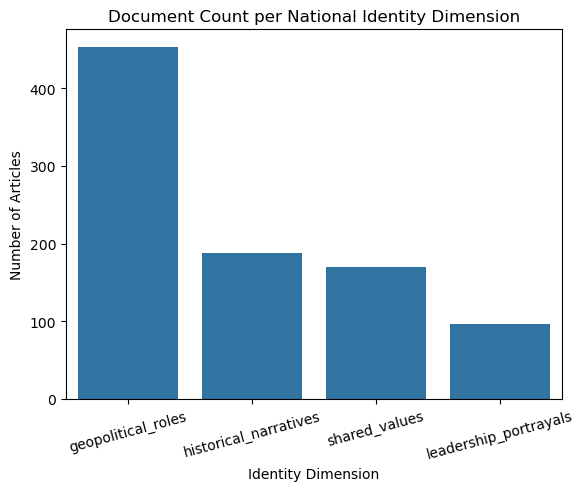

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='identity_dimension', data=nyt_df, order=identity_counts.index)
plt.title("Document Count per National Identity Dimension")
plt.xlabel("Identity Dimension")
plt.ylabel("Number of Articles")
plt.xticks(rotation=15)
plt.show()

<Axes: title={'center': 'LDA Topic Trends Over Time'}, xlabel='month'>

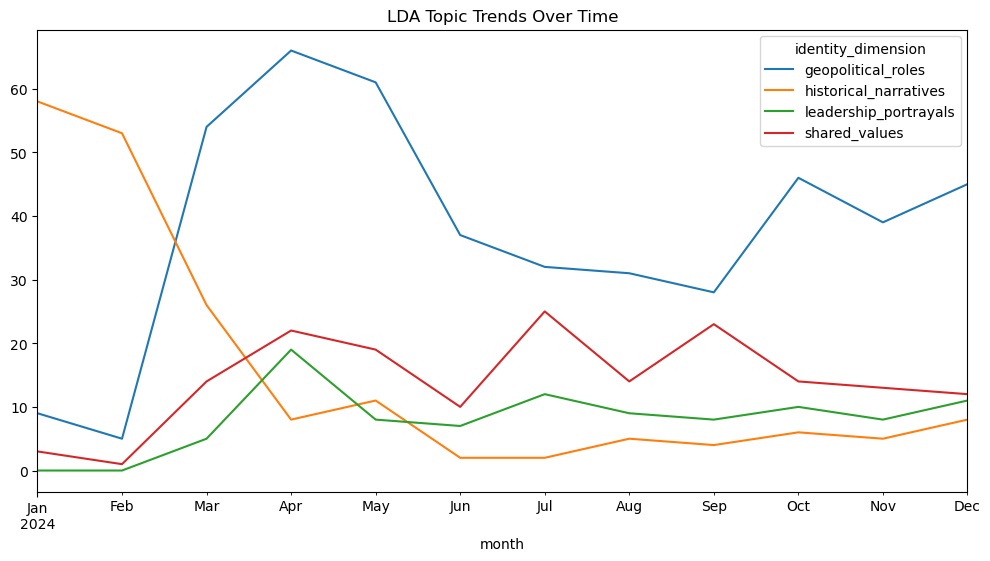

In [12]:
nyt_df['pub_date'] = pd.to_datetime(nyt_df['pub_date'], errors='coerce')  # Coerce invalid dates to NaT
nyt_df['month'] = nyt_df['pub_date'].dt.to_period('M')
topic_over_time = nyt_df.groupby(['month', 'identity_dimension']).size().unstack(fill_value=0)

# Plot
topic_over_time.plot(figsize=(12, 6), title='LDA Topic Trends Over Time')

In [13]:
correlation_matrix = topic_over_time.corr()
print(correlation_matrix)

identity_dimension     geopolitical_roles  historical_narratives  \
identity_dimension                                                 
geopolitical_roles               1.000000              -0.614102   
historical_narratives           -0.614102               1.000000   
leadership_portrayals            0.728599              -0.762931   
shared_values                    0.608911              -0.755764   

identity_dimension     leadership_portrayals  shared_values  
identity_dimension                                           
geopolitical_roles                  0.728599       0.608911  
historical_narratives              -0.762931      -0.755764  
leadership_portrayals               1.000000       0.771910  
shared_values                       0.771910       1.000000  


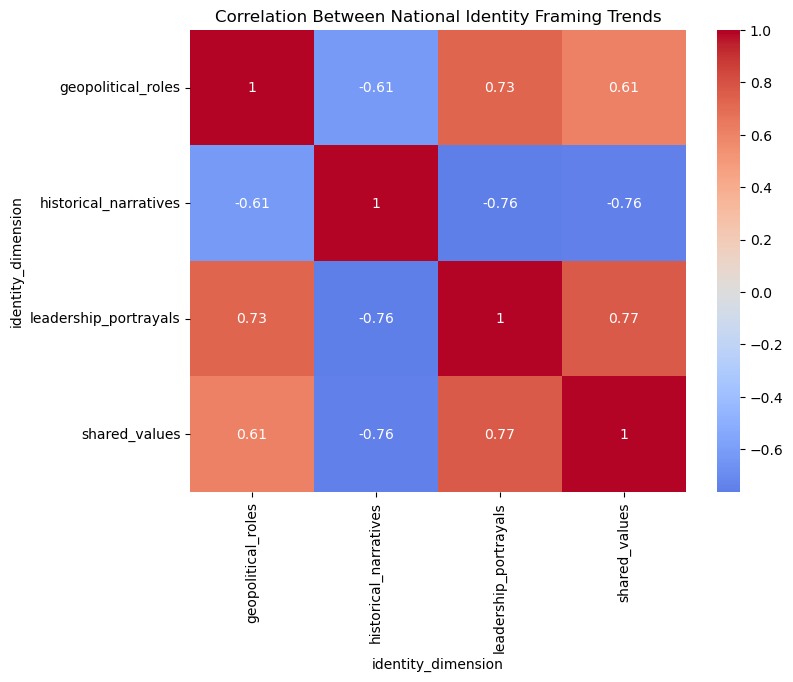

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between National Identity Framing Trends")
plt.show()

In [15]:
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import itertools

# Use your topic_over_time DataFrame
dimensions = topic_over_time.columns.tolist()
max_lag = 2
results = []

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

for cause, effect in itertools.permutations(dimensions, 2):
    try:
        data = topic_over_time[[cause, effect]].dropna()
        test_result = grangercausalitytests(data[[effect, cause]], maxlag=max_lag, verbose=False)

        p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        min_p = min(p_values)

        results.append({
            'cause': cause,
            'effect': effect,
            'min_p_value': min_p
        })
    except Exception as e:
        results.append({
            'cause': cause,
            'effect': effect,
            'min_p_value': None,
            'error': str(e)
        })

# Output table
granger_df = pd.DataFrame(results).sort_values(by='min_p_value')
print(granger_df[['cause', 'effect', 'min_p_value']])

                    cause                 effect  min_p_value
4   historical_narratives  leadership_portrayals     0.004317
7   leadership_portrayals  historical_narratives     0.085558
3   historical_narratives     geopolitical_roles     0.098241
5   historical_narratives          shared_values     0.100037
9           shared_values     geopolitical_roles     0.114193
1      geopolitical_roles  leadership_portrayals     0.123235
6   leadership_portrayals     geopolitical_roles     0.229123
8   leadership_portrayals          shared_values     0.349052
11          shared_values  leadership_portrayals     0.401993
2      geopolitical_roles          shared_values     0.403945
0      geopolitical_roles  historical_narratives     0.468428
10          shared_values  historical_narratives     0.785258


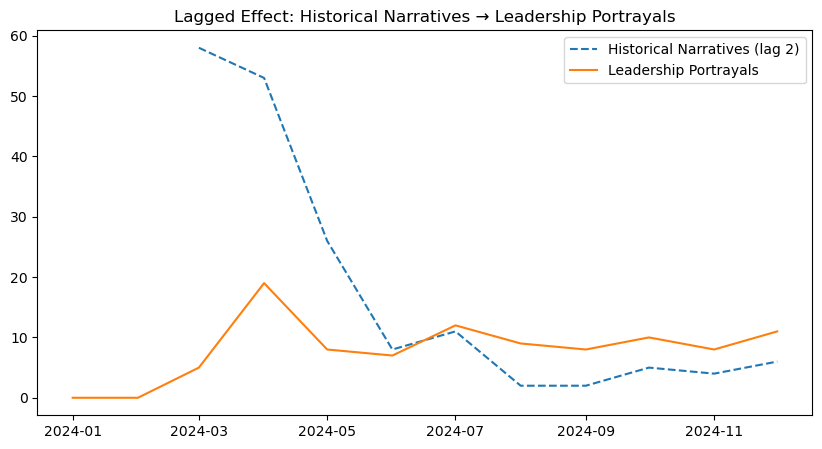

In [16]:
import matplotlib.pyplot as plt

lagged = topic_over_time.copy()
lagged['historical_narratives_lag2'] = lagged['historical_narratives'].shift(2)

plt.figure(figsize=(10, 5))
plt.plot(lagged.index.to_timestamp(), lagged['historical_narratives_lag2'], label='Historical Narratives (lag 2)', linestyle='--')
plt.plot(lagged.index.to_timestamp(), lagged['leadership_portrayals'], label='Leadership Portrayals')
plt.legend()
plt.title("Lagged Effect: Historical Narratives → Leadership Portrayals")
plt.show()

Granger causality analysis suggests that increases in historical narrative framing precede leadership portrayals (p = 0.004), implying that media may frame leadership legitimacy through historical continuity or revision.”

# Sentence-BERT + UMAP + KMeans Clustering

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')  
embeddings = model.encode(nyt_df['clean_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

In [18]:
import umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

nyt_df['umap_x'] = embedding_2d[:, 0]
nyt_df['umap_y'] = embedding_2d[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


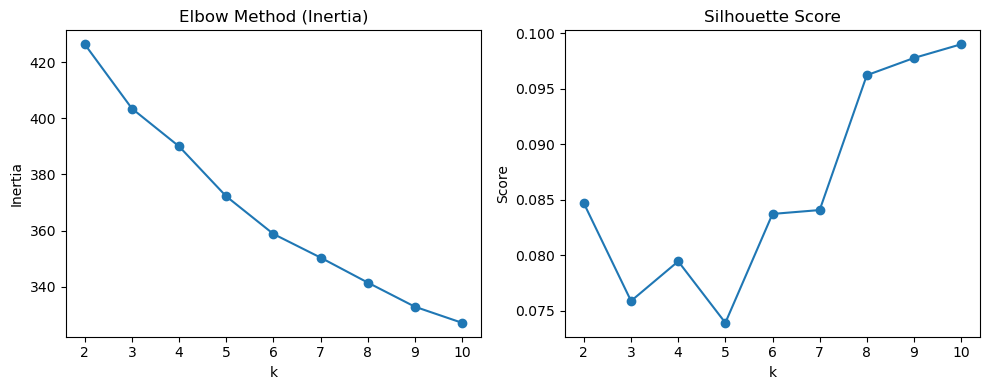

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embeddings, kmeans.labels_))

# Plot elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_range, silhouettes, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [20]:
optimal_k = 8  # Replace with your actual choice
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
nyt_df['cluster'] = kmeans.fit_predict(embeddings)

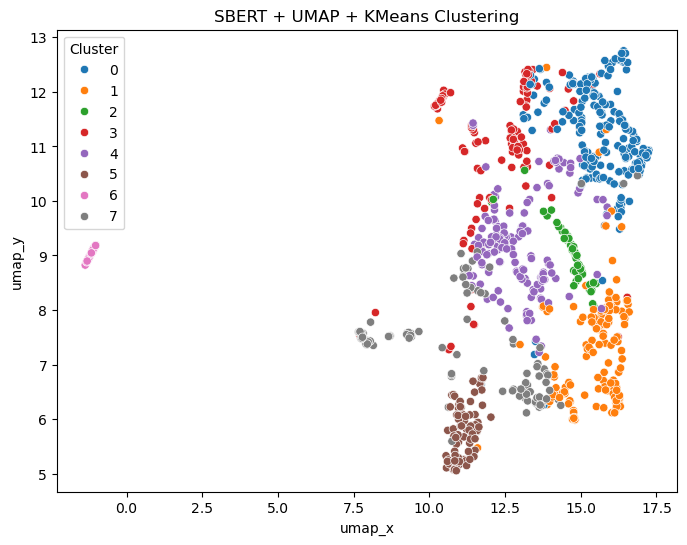

In [21]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=nyt_df, x='umap_x', y='umap_y', hue='cluster', palette='tab10')
plt.title('SBERT + UMAP + KMeans Clustering')
plt.legend(title="Cluster")
plt.show()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(nyt_df['clean_text'])
words = vectorizer.get_feature_names_out()

for i in range(8):
    cluster_mask = nyt_df['cluster'] == i
    cluster_docs = X[cluster_mask.values, :]
    
    word_sums = cluster_docs.sum(axis=0).A1
    top_idx = word_sums.argsort()[::-1][:10]
    top_words = [words[j] for j in top_idx]
    
    print(f"Cluster {i}: {', '.join(top_words)}")



    

Cluster 0: china, said, chinese, company, state, year, united, tariff, country, car
Cluster 1: china, said, russia, state, chinese, country, united, ukraine, president, war
Cluster 2: taiwan, china, said, chinese, island, beijing, lai, military, state, taiwanese
Cluster 3: china, said, year, chinese, people, time, term, city, advertisement, country
Cluster 4: china, said, chinese, government, hong, kong, year, state, official, company
Cluster 5: tiktok, said, company, app, chinese, law, bytedance, trump, state, government
Cluster 6: wada, chinese, swimmer, positive, said, time, doping, agency, athlete, china
Cluster 7: like, said, think, people, time, tiktok, china, going, new, year


In [23]:
anchors = [
    "global power", "military threat", "world leadership", "geopolitical influence",
    "historical legacy", "past injustice", "imperialism",
    "strong leadership", "state governance", "dictatorship",
    "freedom and democracy", "rule of law", "human rights", "national pride"
]
anchor_vecs = model.encode(anchors)

In [24]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cluster_labels = []

for i in range(8):
    cluster_vecs = embeddings[nyt_df['cluster'] == i]
    centroid = np.mean(cluster_vecs, axis=0, keepdims=True)
    
    sims = cosine_similarity(centroid, anchor_vecs)[0]
    best_idx = np.argmax(sims)
    best_anchor = anchors[best_idx]
    
    cluster_labels.append((i, best_anchor, round(sims[best_idx], 3)))

In [25]:
for cid, label, score in cluster_labels:
    print(f"Cluster {cid} → {label} (cosine sim: {score})")

Cluster 0 → geopolitical influence (cosine sim: 0.39500001072883606)
Cluster 1 → geopolitical influence (cosine sim: 0.5099999904632568)
Cluster 2 → geopolitical influence (cosine sim: 0.45899999141693115)
Cluster 3 → state governance (cosine sim: 0.36399999260902405)
Cluster 4 → state governance (cosine sim: 0.39500001072883606)
Cluster 5 → dictatorship (cosine sim: 0.3580000102519989)
Cluster 6 → state governance (cosine sim: 0.2849999964237213)
Cluster 7 → historical legacy (cosine sim: 0.35600000619888306)


In [26]:
label_map = {cid: label for cid, label, _ in cluster_labels}
nyt_df['semantic_label'] = nyt_df['cluster'].map(label_map)

In [27]:
centroids = nyt_df.groupby('cluster')[['umap_x', 'umap_y']].mean()
centroids['semantic_label'] = centroids.index.map(label_map)

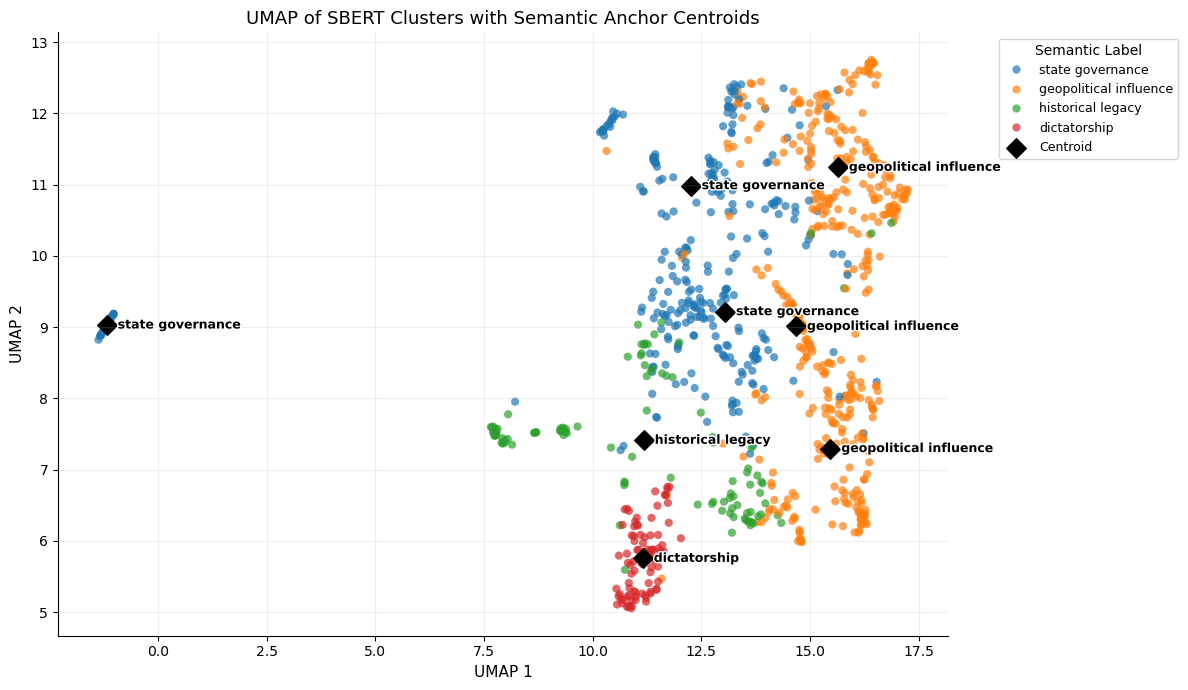

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

plt.figure(figsize=(12, 7))

# Use a clean, professional palette
palette = sns.color_palette("tab10", n_colors=nyt_df['semantic_label'].nunique())

# Plot UMAP points
sns.scatterplot(
    data=nyt_df,
    x='umap_x', y='umap_y',
    hue='semantic_label',
    palette=palette,
    alpha=0.7,
    s=35,
    edgecolor='none'
)

# Plot centroids as diamonds
plt.scatter(
    centroids['umap_x'],
    centroids['umap_y'],
    c='black',
    marker='D',  # Diamond marker
    s=100,
    label='Centroid'
)

# Annotate centroids with smaller font
for _, row in centroids.iterrows():
    plt.text(
        row['umap_x'] + 0.25, row['umap_y'],
        row['semantic_label'],
        fontsize=9,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
        ha='left',
        va='center'
    )

# Style
plt.title("UMAP of SBERT Clusters with Semantic Anchor Centroids", fontsize=13)
plt.xlabel("UMAP 1", fontsize=11)
plt.ylabel("UMAP 2", fontsize=11)
plt.legend(title='Semantic Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

In [29]:
anchor_map = {cid: anchor for cid, anchor, _ in cluster_labels}
nyt_df['merged_label'] = nyt_df['cluster'].map(anchor_map)

In [30]:
# Group by merged_label instead of cluster
centroids = nyt_df.groupby('merged_label')[['umap_x', 'umap_y']].mean().reset_index()

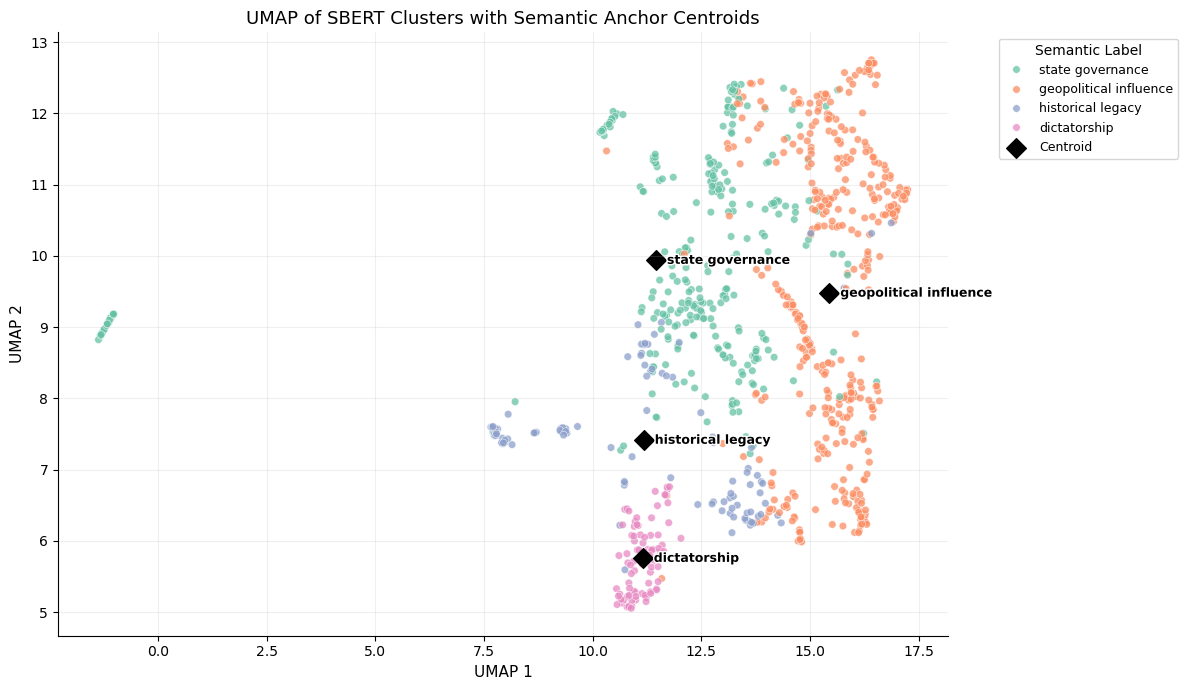

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

plt.figure(figsize=(12, 7))

# Use a clean, professional palette
palette = sns.color_palette("tab10", n_colors=nyt_df['semantic_label'].nunique())

# Plot UMAP points
sns.scatterplot(
    data=nyt_df,
    x='umap_x', y='umap_y',
    hue='merged_label',
    palette='Set2',
    s=30,
    alpha=0.75
)
# Plot centroids as diamonds
plt.scatter(
    centroids['umap_x'],
    centroids['umap_y'],
    c='black',
    marker='D',  # Diamond marker
    s=100,
    label='Centroid'
)

# Annotate centroids with smaller font


for _, row in centroids.iterrows():
    plt.text(
        row['umap_x'] + 0.25, row['umap_y'],
        row['merged_label'],
        fontsize=9,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
        ha='left',
        va='center'
    )

# Style
plt.title("UMAP of SBERT Clusters with Semantic Anchor Centroids", fontsize=13)
plt.xlabel("UMAP 1", fontsize=11)
plt.ylabel("UMAP 2", fontsize=11)
plt.legend(title='Semantic Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

# vedar 

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [33]:
nyt_df['sentiment'] = nyt_df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [34]:
sentiment_by_label = nyt_df.groupby('merged_label')['sentiment'].agg(['mean', 'std', 'count']).sort_values('mean')
display(sentiment_by_label)

,mean,std,count
merged_label,,,
historical legacy,0.300927,0.836828,109
state governance,0.362227,0.813006,305
geopolitical influence,0.526665,0.761265,406
dictatorship,0.601015,0.691960,88


<Axes: title={'center': 'Average Sentiment Over Time by National Identity Frame'}, xlabel='month'>

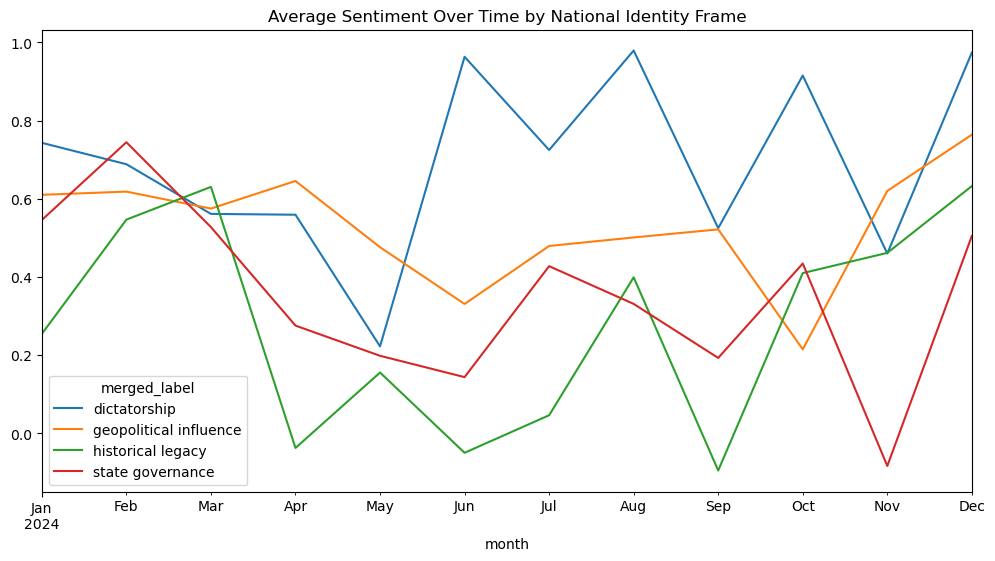

In [35]:
nyt_df['month'] = pd.to_datetime(nyt_df['pub_date']).dt.to_period('M')
sentiment_over_time = nyt_df.groupby(['month', 'merged_label'])['sentiment'].mean().unstack()
sentiment_over_time.plot(figsize=(12, 6), title="Average Sentiment Over Time by National Identity Frame")

/var/folders/0k/7z1g8vr51n7_n_22vk6x3zrw0000gn/T/ipykernel_3195/2338083434.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha='right')


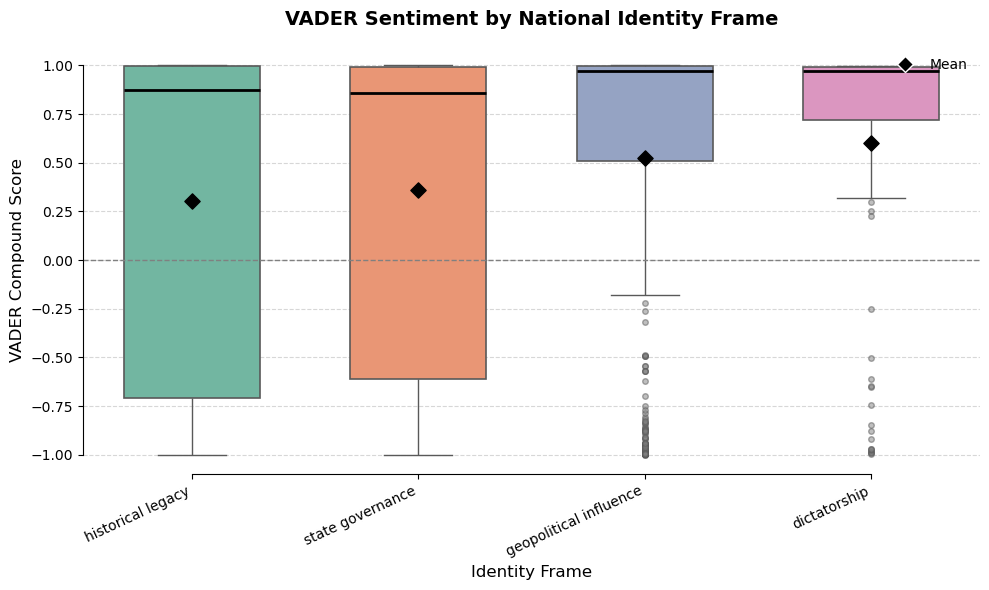

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1. Compute mean sentiment per frame and sort frames by mean
means = nyt_df.groupby('merged_label')['sentiment'].mean().sort_values()
labels = means.index.tolist()

# 2. Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Draw boxplots in the order of sorted means
sns.boxplot(
    x='merged_label',
    y='sentiment',
    data=nyt_df,
    order=labels,
    palette='Set2',
    width=0.6,
    fliersize=3,
    linewidth=1.2,
    medianprops={'color': 'black', 'linewidth': 2},
    whiskerprops={'linewidth': 1},
    capprops={'linewidth': 1},
    flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'alpha': 0.5, 'markersize': 4},
    ax=ax
)

# 4. Overlay mean markers (diamond), once per frame
for i, lbl in enumerate(labels):
    ax.scatter(i, means[lbl], color='black', marker='D', s=60, zorder=3)

# 5. Draw a zero‐line for reference
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# 6. Tidy up axes, labels, title
ax.set_title("VADER Sentiment by National Identity Frame", fontsize=14, weight='bold', pad=15)
ax.set_xlabel("Identity Frame", fontsize=12)
ax.set_ylabel("VADER Compound Score", fontsize=12)
ax.set_xticklabels(labels, rotation=25, ha='right')
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
sns.despine(trim=True)
plt.tight_layout()

# 7. Manually add a legend entry for the mean marker
legend_elements = [
    Line2D([0], [0], marker='D', color='w', label='Mean', markerfacecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [37]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. One-way ANOVA
groups = [nyt_df.loc[nyt_df['merged_label']==lbl, 'sentiment'] for lbl in labels]
f, p = stats.f_oneway(*groups)
print(f"ANOVA F-statistic={f:.2f}, p={p:.3g}")

# 2. Tukey’s HSD for pairwise comparisons
tukey = pairwise_tukeyhsd(nyt_df['sentiment'], nyt_df['merged_label'], alpha=0.05)
print(tukey.summary())

ANOVA F-statistic=4.99, p=0.00193
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
          dictatorship geopolitical influence  -0.0743 0.8505  -0.311  0.1623  False
          dictatorship      historical legacy  -0.3001 0.0378 -0.5886 -0.0116   True
          dictatorship       state governance  -0.2388 0.0571 -0.4824  0.0048  False
geopolitical influence      historical legacy  -0.2257  0.038 -0.4429 -0.0086   True
geopolitical influence       state governance  -0.1644 0.0288  -0.317 -0.0119   True
     historical legacy       state governance   0.0613 0.8962 -0.1633  0.2859  False
------------------------------------------------------------------------------------


<Figure size 1200x500 with 0 Axes>

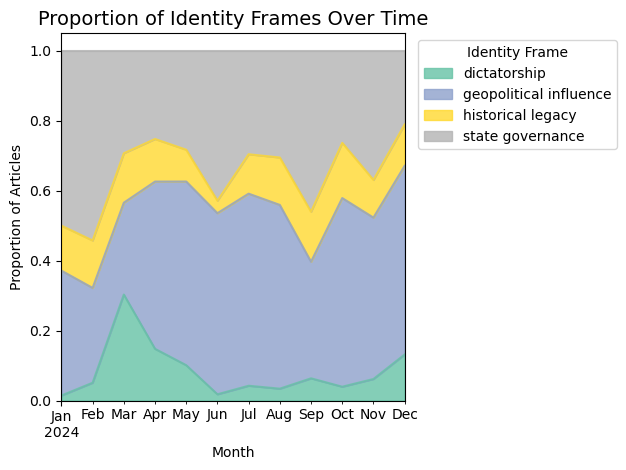

In [38]:
# 1. Compute monthly counts and proportions
monthly_counts = (nyt_df
                  .groupby(['month','merged_label'])
                  .size()
                  .unstack(fill_value=0))
monthly_prop = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# 2. Plot as stacked area
plt.figure(figsize=(12, 5))
monthly_prop.plot.area(colormap='Set2', alpha=0.8)
plt.title("Proportion of Identity Frames Over Time", fontsize=14)
plt.ylabel("Proportion of Articles")
plt.xlabel("Month")
plt.legend(title="Identity Frame", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

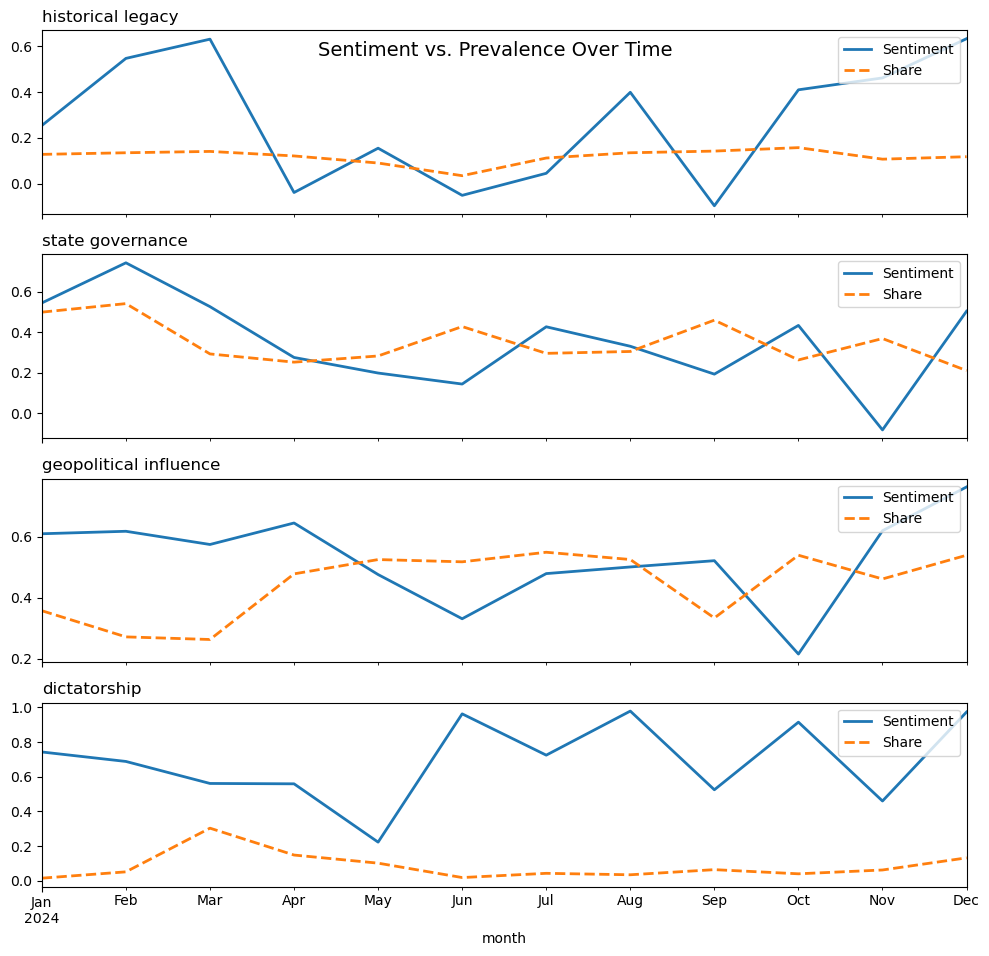

In [39]:
fig, axes = plt.subplots(len(labels), 1, figsize=(10, 2.5*len(labels)), sharex=True)

for ax, lbl in zip(axes, labels):
    # sentiment
    sentiment_over_time[lbl].plot(ax=ax, color='C0', label='Sentiment', linewidth=2)
    # prevalence
    (monthly_prop[lbl] * 1.0).plot(ax=ax, color='C1', linestyle='--', label='Share', linewidth=2)
    
    ax.set_title(lbl, loc='left', fontsize=12)
    ax.legend(loc='upper right')

plt.suptitle("Sentiment vs. Prevalence Over Time", fontsize=14, y=0.92)
plt.tight_layout()
plt.show()

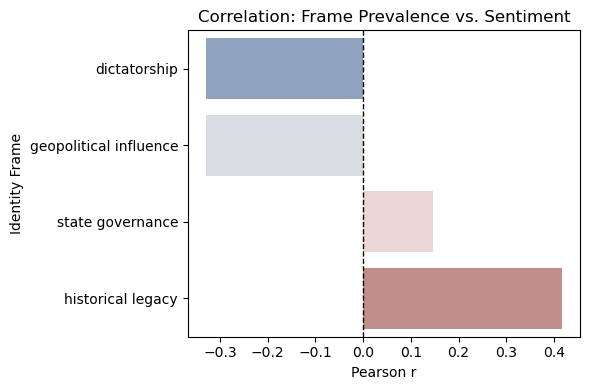

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make sure monthly_prop (share) and sentiment_over_time have the same index & columns
#    monthly_prop.columns and sentiment_over_time.columns should both be your merged_label list.

# 2. Compute per-frame correlations
corrs = {
    frame: monthly_prop[frame].corr(sentiment_over_time[frame])
    for frame in monthly_prop.columns
}

corr_series = pd.Series(corrs).sort_values()

# 3. Plot as a bar chart
plt.figure(figsize=(6,4))
sns.barplot(
    x=corr_series.values,
    y=corr_series.index,
    palette='vlag',   # red–white–blue diverging
)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title("Correlation: Frame Prevalence vs. Sentiment")
plt.xlabel("Pearson r")
plt.ylabel("Identity Frame")
plt.tight_layout()
plt.show()

# stance

In [41]:
from transformers import pipeline
import pandas as pd

# Load the zero-shot classifier (uses MNLI under the hood)
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0       # set to -1 if you have no GPU
)

Device set to use mps:0


In [42]:
import torch
import numpy as np
from transformers import pipeline, AutoTokenizer

# 1) Device & Model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model_name = "typeform/distilbert-base-uncased-mnli"

tokenizer  = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    tokenizer=tokenizer,
    device=0 if device=="mps" else -1,
    truncation=True,
    max_length=tokenizer.model_max_length,
    batch_size=16
)

# 2) Chunking + classification
def classify_long_text(text, labels):
    max_len = tokenizer.model_max_length
    words   = text.split()
    chunks  = [" ".join(words[i:i+max_len]) for i in range(0, len(words), max_len)]
    scores  = {lab: [] for lab in labels}
    for out in classifier(chunks, candidate_labels=labels):
        for lab, sc in zip(out["labels"], out["scores"]):
            scores[lab].append(sc)
    avg_scores = {lab: np.mean(scores[lab]) for lab in labels}
    return max(avg_scores, key=avg_scores.get)

# 3) Run on your DataFrame
stance_labels = ["support", "neutral", "oppose"]
nyt_df['stance'] = nyt_df['clean_text'].apply(lambda txt: classify_long_text(txt, stance_labels))

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Device set to use mps:0


In [43]:
nyt_df['stance'].value_counts(normalize=True)

stance
support    0.386564
oppose     0.314978
neutral    0.298458
Name: proportion, dtype: float64

<Figure size 800x500 with 0 Axes>

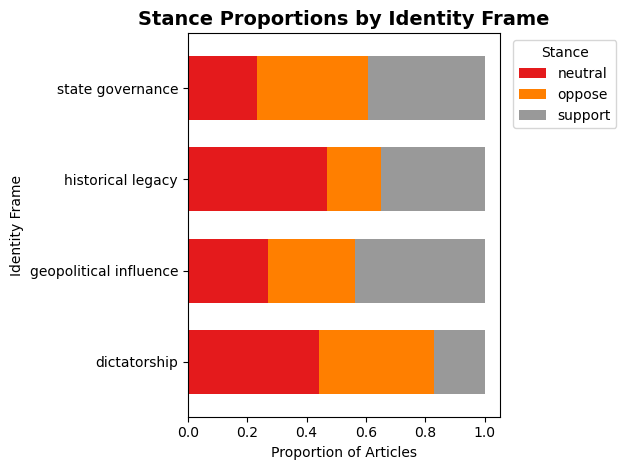

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Build a crosstab of counts
stance_counts = pd.crosstab(nyt_df['merged_label'], nyt_df['stance'])

# 2. Convert to proportions
stance_prop = stance_counts.div(stance_counts.sum(axis=1), axis=0)

# 3. Plot
plt.figure(figsize=(8,5))
stance_prop.plot(
    kind='barh',
    stacked=True,
    colormap='Set1',
    width=0.7
)
plt.title("Stance Proportions by Identity Frame", fontsize=14, weight='bold')
plt.xlabel("Proportion of Articles")
plt.ylabel("Identity Frame")
plt.legend(title="Stance", bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

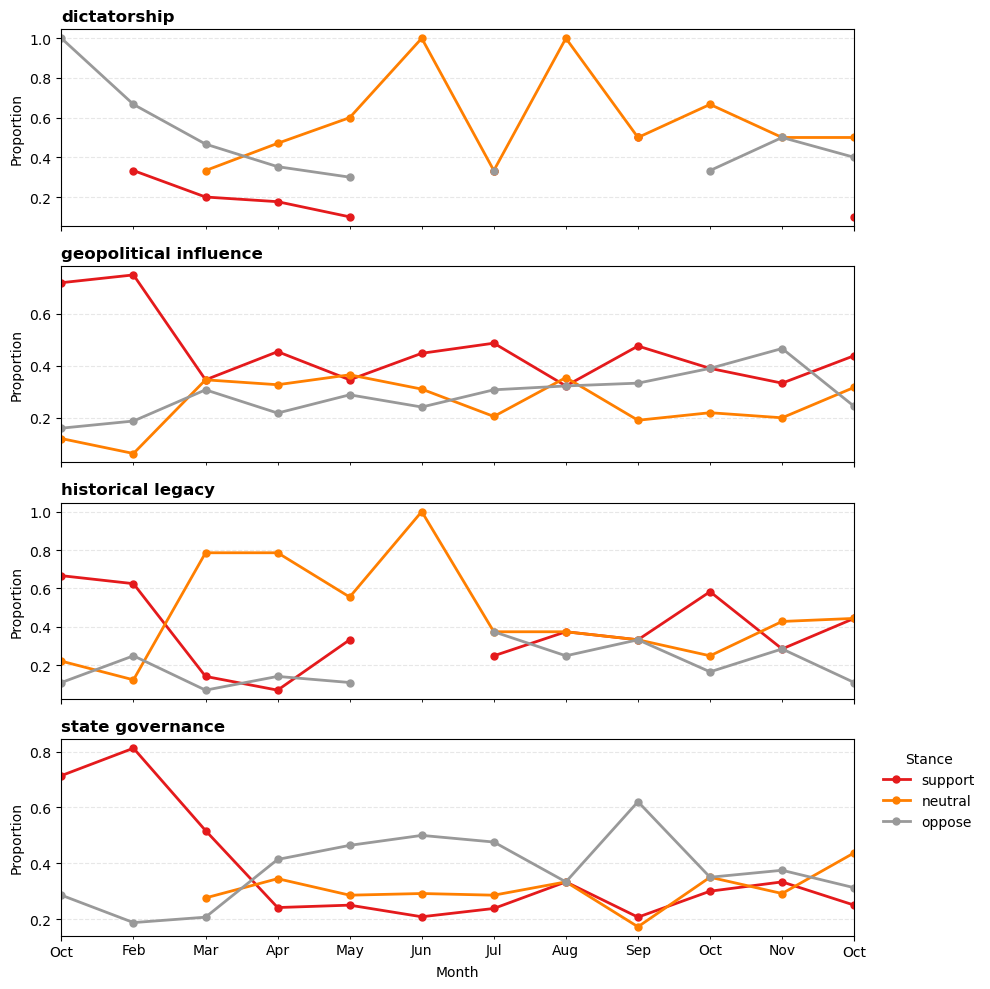

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Prepare the time-stance DataFrame exactly once
df_ts = (
    nyt_df
    .groupby(['month','merged_label','stance'])
    .size()
    .rename("count")
    .reset_index()
)
totals = df_ts.groupby(['month','merged_label'])['count'].transform('sum')
df_ts['prop'] = df_ts['count'] / totals

# Convert Period to Timestamp so matplotlib knows it’s dates
df_ts['month'] = df_ts['month'].dt.to_timestamp()

frames = df_ts['merged_label'].unique()
n = len(frames)
fig, axes = plt.subplots(n, 1, figsize=(10, 2.5*n), sharex=True)

for ax, frame in zip(axes, frames):
    # Pivot for this frame
    df_frame = (
        df_ts[df_ts['merged_label']==frame]
        .pivot(index='month', columns='stance', values='prop')
        .reindex(columns=['support','neutral','oppose'])
    )
    # Plot each stance
    df_frame.plot(
        ax=ax,
        marker='o',
        linewidth=2,
        markersize=5,
        colormap='Set1',
        legend=False
    )
    ax.set_title(frame, loc='left', fontsize=12, weight='bold')
    ax.set_ylabel("Proportion")
    ax.grid(alpha=0.3, linestyle='--')
    # Hide x-tick labels here; only bottom will show
    ax.tick_params(labelbottom=False)

# Now format the bottom axes
bottom_ax = axes[-1]
bottom_ax.tick_params(labelbottom=True)
bottom_ax.xaxis.set_major_locator(mdates.MonthLocator())
bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
bottom_ax.set_xlabel("Month")

# Add a single legend on the bottom plot
bottom_ax.legend(title='Stance', bbox_to_anchor=(1.02,1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

# suprevised model


In [46]:
# import pandas as pd

# # 1) How many per frame?
# counts = nyt_df['merged_label'].value_counts()
# print("Articles per frame before sampling:\n", counts)

# # 2) Stratified sample: up to 50 articles per frame
# sampled = (
#     nyt_df
#     .groupby('merged_label', group_keys=False)
#     .apply(lambda grp: grp.sample(n=min(len(grp), 50), random_state=42))
#     .reset_index(drop=True)
# )

# # 3) Inspect breakdown
# print("\nSampled articles per frame:\n", sampled['merged_label'].value_counts())

# # 4) Export for annotation (clean_text + current merged_label as context)
# sampled[['clean_text','merged_label']] \
#     .to_csv('frame_annotation_sample.csv', index=False)

# print("\nExported", len(sampled), "rows to frame_annotation_sample.csv")


# BERT Model